<a href="https://colab.research.google.com/github/xaviertheofilus/optmizing_otsu_tresholding_using_ga/blob/main/task_final_project_control_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab import files
from google.colab import drive
import random
from typing import Tuple, List
import seaborn as sns
from sklearn.metrics import mean_squared_error
import zipfile
import os


In [ ]:
class GAOtsuThresholding:
    """
    Implementasi Genetic Algorithm untuk optimasi Otsu Thresholding
    dengan fokus pada segmentasi citra medis (tumor otak)
    """

    def __init__(self, pop_size=30, generations=50, mutation_rate=0.1, crossover_rate=0.8):
        """
        Inisialisasi parameter GA yang dioptimalkan untuk efisiensi

        Args:
            pop_size: Ukuran populasi (dikurangi untuk efisiensi)
            generations: Jumlah generasi (disesuaikan untuk konvergensi cepat)
            mutation_rate: Tingkat mutasi
            crossover_rate: Tingkat crossover
        """
        self.pop_size = pop_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate

        # Tracking untuk analisis
        self.fitness_history = []
        self.best_threshold_history = []

    def otsu_fitness(self, image: np.ndarray, threshold: int) -> float:
        """
        Menghitung fungsi fitness berdasarkan kriteria Otsu
        Memaksimalkan varian antar-kelas untuk segmentasi optimal
        """
        # Hitung histogram
        hist = cv2.calcHist([image], [0], None, [256], [0, 256]).flatten()
        hist = hist.astype(np.float64)

        # Normalisasi probabilitas
        total_pixels = image.size
        prob = hist / total_pixels

        # Hitung probabilitas kumulatif dan mean
        w0 = np.sum(prob[:threshold])  # Probabilitas background
        w1 = np.sum(prob[threshold:])  # Probabilitas foreground

        # Hindari pembagian dengan nol
        if w0 == 0 or w1 == 0:
            return 0

        # Hitung mean intensitas untuk setiap kelas
        mu0 = np.sum(np.arange(threshold) * prob[:threshold]) / w0
        mu1 = np.sum(np.arange(threshold, 256) * prob[threshold:]) / w1

        # Varian antar-kelas (Otsu criterion)
        between_class_variance = w0 * w1 * (mu0 - mu1) ** 2

        return between_class_variance

    def initialize_population(self) -> List[int]:
        """Membuat populasi awal dengan distribusi yang baik"""
        return [random.randint(1, 254) for _ in range(self.pop_size)]

    def tournament_selection(self, population: List[int], fitness: List[float]) -> int:
        """Seleksi turnamen untuk memilih parent terbaik"""
        tournament_size = 3
        indices = random.sample(range(len(population)), tournament_size)
        best_idx = max(indices, key=lambda i: fitness[i])
        return population[best_idx]

    def crossover(self, parent1: int, parent2: int) -> Tuple[int, int]:
        """Crossover aritmatik untuk menghasilkan offspring"""
        if random.random() < self.crossover_rate:
            alpha = random.random()
            child1 = int(alpha * parent1 + (1 - alpha) * parent2)
            child2 = int(alpha * parent2 + (1 - alpha) * parent1)

            # Pastikan dalam range valid
            child1 = max(1, min(254, child1))
            child2 = max(1, min(254, child2))

            return child1, child2
        return parent1, parent2

    def mutate(self, individual: int) -> int:
        """Mutasi dengan gaussian noise"""
        if random.random() < self.mutation_rate:
            noise = random.randint(-15, 15)
            mutated = individual + noise
            return max(1, min(254, mutated))
        return individual

    def optimize(self, image: np.ndarray, verbose=True) -> Tuple[int, float]:
        """
        Proses optimasi utama GA

        Returns:
            Tuple berisi (threshold_optimal, fitness_optimal)
        """
        # Reset history
        self.fitness_history = []
        self.best_threshold_history = []

        # Inisialisasi populasi
        population = self.initialize_population()

        for gen in range(self.generations):
            # Evaluasi fitness untuk seluruh populasi
            fitness_scores = [self.otsu_fitness(image, thresh) for thresh in population]

            # Tracking best individual
            best_idx = np.argmax(fitness_scores)
            best_fitness = fitness_scores[best_idx]
            best_threshold = population[best_idx]

            # Simpan history
            self.fitness_history.append(best_fitness)
            self.best_threshold_history.append(best_threshold)

            # Progress report
            if verbose and gen % 10 == 0:
                print(f"Generation {gen}: Best Threshold = {best_threshold}, Fitness = {best_fitness:.6f}")

            # Evolusi populasi baru
            new_population = [best_threshold]  # Elitism

            while len(new_population) < self.pop_size:
                # Seleksi parents
                parent1 = self.tournament_selection(population, fitness_scores)
                parent2 = self.tournament_selection(population, fitness_scores)

                # Crossover dan mutasi
                child1, child2 = self.crossover(parent1, parent2)
                child1 = self.mutate(child1)
                child2 = self.mutate(child2)

                new_population.extend([child1, child2])

            population = new_population[:self.pop_size]

        # Return best solution
        final_fitness = [self.otsu_fitness(image, thresh) for thresh in population]
        best_idx = np.argmax(final_fitness)

        return population[best_idx], final_fitness[best_idx]


In [ ]:
def load_brain_tumor_dataset():
    """
    Memuat dataset tumor otak dari Google Drive atau upload file
    """
    print("=== LOADING BRAIN TUMOR DATASET ===")
    print("Pilih metode loading dataset:")
    print("1. Upload file ZIP")
    print("2. Dari Google Drive")

    choice = input("Masukkan pilihan (1/2): ")

    if choice == "1":
        # Upload file
        print("Upload file ZIP berisi citra tumor otak...")
        uploaded = files.upload()

        # Extract ZIP
        for filename in uploaded.keys():
            if filename.endswith('.zip'):
                with zipfile.ZipFile(filename, 'r') as zip_ref:
                    zip_ref.extractall('dataset')
                print(f"Dataset berhasil diekstrak ke folder 'dataset'")
                return 'dataset'

    elif choice == "2":
        # Mount Google Drive
        drive.mount('/content/drive')
        dataset_path = input("Masukkan path dataset di Google Drive: ")
        return dataset_path

    return None

def load_single_image(image_path: str) -> np.ndarray:
    """
    Memuat dan preprocessing citra tunggal
    """
    # Baca citra
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if image is None:
        raise ValueError(f"Tidak dapat memuat citra: {image_path}")

    # Resize untuk efisiensi komputasi
    height, width = image.shape
    if height > 512 or width > 512:
        scale = 512 / max(height, width)
        new_height = int(height * scale)
        new_width = int(width * scale)
        image = cv2.resize(image, (new_width, new_height))

    # Noise reduction
    image = cv2.medianBlur(image, 3)

    return image

def apply_threshold(image: np.ndarray, threshold: int) -> np.ndarray:
    """Aplikasi thresholding biner"""
    return (image > threshold).astype(np.uint8) * 255

def calculate_traditional_otsu(image: np.ndarray) -> int:
    """Hitung threshold menggunakan metode Otsu tradisional (OpenCV)"""
    threshold, _ = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return int(threshold)


In [ ]:
def create_comprehensive_analysis(image: np.ndarray, ga_threshold: int,
                                traditional_threshold: int, ga_optimizer: GAOtsuThresholding):
    """
    Membuat visualisasi komprehensif untuk analisis hasil
    """
    plt.style.use('default')
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))

    # 1. Citra Original
    axes[0,0].imshow(image, cmap='gray')
    axes[0,0].set_title('Citra Original', fontweight='bold')
    axes[0,0].axis('off')

    # 2. Histogram dengan threshold lines
    hist = cv2.calcHist([image], [0], None, [256], [0, 256]).flatten()
    axes[0,1].plot(hist, color='blue', linewidth=2)
    axes[0,1].axvline(ga_threshold, color='red', linestyle='--', linewidth=2,
                     label=f'GA: {ga_threshold}')
    axes[0,1].axvline(traditional_threshold, color='green', linestyle='--', linewidth=2,
                     label=f'Otsu: {traditional_threshold}')
    axes[0,1].set_title('Histogram dengan Threshold', fontweight='bold')
    axes[0,1].set_xlabel('Intensitas Pixel')
    axes[0,1].set_ylabel('Frekuensi')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # 3. Hasil GA Thresholding
    ga_result = apply_threshold(image, ga_threshold)
    axes[0,2].imshow(ga_result, cmap='gray')
    axes[0,2].set_title(f'GA Threshold: {ga_threshold}', fontweight='bold')
    axes[0,2].axis('off')

    # 4. Hasil Traditional Otsu
    otsu_result = apply_threshold(image, traditional_threshold)
    axes[0,3].imshow(otsu_result, cmap='gray')
    axes[0,3].set_title(f'Traditional Otsu: {traditional_threshold}', fontweight='bold')
    axes[0,3].axis('off')

    # 5. Evolusi Fitness
    axes[1,0].plot(ga_optimizer.fitness_history, 'b-', linewidth=2, marker='o', markersize=3)
    axes[1,0].set_title('Evolusi Fitness', fontweight='bold')
    axes[1,0].set_xlabel('Generasi')
    axes[1,0].set_ylabel('Fitness Score')
    axes[1,0].grid(True, alpha=0.3)

    # 6. Evolusi Threshold
    axes[1,1].plot(ga_optimizer.best_threshold_history, 'r-', linewidth=2, marker='s', markersize=3)
    axes[1,1].axhline(traditional_threshold, color='green', linestyle='--', linewidth=2,
                     label=f'Otsu: {traditional_threshold}')
    axes[1,1].set_title('Evolusi Threshold', fontweight='bold')
    axes[1,1].set_xlabel('Generasi')
    axes[1,1].set_ylabel('Nilai Threshold')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

    # 7. Perbandingan Fitness
    ga_fitness = ga_optimizer.otsu_fitness(image, ga_threshold)
    otsu_fitness = ga_optimizer.otsu_fitness(image, traditional_threshold)

    methods = ['GA Method', 'Traditional Otsu']
    fitness_scores = [ga_fitness, otsu_fitness]

    bars = axes[1,2].bar(methods, fitness_scores, color=['red', 'green'], alpha=0.7)
    axes[1,2].set_title('Perbandingan Fitness', fontweight='bold')
    axes[1,2].set_ylabel('Fitness Score')

    # Tambahkan nilai pada bar
    for bar, score in zip(bars, fitness_scores):
        axes[1,2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.0001,
                      f'{score:.5f}', ha='center', va='bottom', fontweight='bold')

    # 8. Statistik Segmentasi
    ga_white_pixels = np.sum(ga_result == 255)
    otsu_white_pixels = np.sum(otsu_result == 255)
    total_pixels = image.size

    stats_text = f"""HASIL ANALISIS:

GA Method:
• Threshold: {ga_threshold}
• Fitness: {ga_fitness:.6f}
• Pixel Putih: {ga_white_pixels:,} ({ga_white_pixels/total_pixels*100:.1f}%)

Traditional Otsu:
• Threshold: {traditional_threshold}
• Fitness: {otsu_fitness:.6f}
• Pixel Putih: {otsu_white_pixels:,} ({otsu_white_pixels/total_pixels*100:.1f}%)

Perbedaan:
• Threshold: {abs(ga_threshold - traditional_threshold)}
• Fitness: {abs(ga_fitness - otsu_fitness):.6f}
"""

    axes[1,3].text(0.05, 0.95, stats_text, transform=axes[1,3].transAxes,
                   fontsize=10, verticalalignment='top', fontfamily='monospace',
                   bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))
    axes[1,3].axis('off')

    plt.tight_layout()
    plt.suptitle('Analisis Genetic Algorithm vs Traditional Otsu Thresholding',
                 fontsize=16, fontweight='bold', y=1.02)

    return fig


In [ ]:
def run_brain_tumor_segmentation():
    """
    Fungsi utama untuk menjalankan eksperimen segmentasi tumor otak
    """
    print("=== GENETIC ALGORITHM UNTUK SEGMENTASI TUMOR OTAK ===\n")

    # Load dataset
    dataset_path = load_brain_tumor_dataset()
    if dataset_path is None:
        print("Gagal memuat dataset!")
        return

    # Pilih file citra untuk diproses
    print("\nMasukkan path lengkap file citra yang akan diproses:")
    image_path = input("Path citra: ")

    try:
        # Load dan preprocessing citra
        print("Memuat dan preprocessing citra...")
        image = load_single_image(image_path)
        print(f"Ukuran citra: {image.shape}")

        # Inisialisasi GA
        print("\nInisialisasi Genetic Algorithm...")
        ga_optimizer = GAOtsuThresholding(
            pop_size=30,      # Efisien untuk Google Colab
            generations=50,   # Cukup untuk konvergensi
            mutation_rate=0.1,
            crossover_rate=0.8
        )

        # Jalankan optimasi GA
        print("\nMemulai proses optimasi...")
        print("-" * 50)
        ga_threshold, ga_fitness = ga_optimizer.optimize(image, verbose=True)
        print("-" * 50)

        # Hitung traditional Otsu untuk perbandingan
        print("Menghitung Traditional Otsu...")
        traditional_threshold = calculate_traditional_otsu(image)
        traditional_fitness = ga_optimizer.otsu_fitness(image, traditional_threshold)

        # Tampilkan hasil
        print(f"\n=== HASIL PERBANDINGAN ===")
        print(f"GA Threshold: {ga_threshold} (Fitness: {ga_fitness:.6f})")
        print(f"Traditional Otsu: {traditional_threshold} (Fitness: {traditional_fitness:.6f})")

        if ga_fitness > traditional_fitness:
            print("✓ GA menemukan solusi yang lebih baik!")
        else:
            print("→ Traditional Otsu memberikan hasil yang sama atau lebih baik")

        # Buat visualisasi komprehensif
        print("\nMembuat visualisasi analisis...")
        fig = create_comprehensive_analysis(image, ga_threshold, traditional_threshold, ga_optimizer)
        plt.show()

        # Simpan hasil
        save_choice = input("\nSimpan hasil analisis? (y/n): ")
        if save_choice.lower() == 'y':
            fig.savefig('ga_otsu_analysis.png', dpi=300, bbox_inches='tight')
            print("Hasil disimpan sebagai 'ga_otsu_analysis.png'")

        return {
            'ga_threshold': ga_threshold,
            'ga_fitness': ga_fitness,
            'traditional_threshold': traditional_threshold,
            'traditional_fitness': traditional_fitness,
            'image_shape': image.shape
        }

    except Exception as e:
        print(f"Error: {e}")
        return None

=== GENETIC ALGORITHM UNTUK SEGMENTASI TUMOR OTAK ===

=== LOADING BRAIN TUMOR DATASET ===
Pilih metode loading dataset:
1. Upload file ZIP
2. Dari Google Drive
Masukkan pilihan (1/2): 1
Upload file ZIP berisi citra tumor otak...


Saving brain_tumor_dataset-20250622T050425Z-1-001.zip to brain_tumor_dataset-20250622T050425Z-1-001.zip
Dataset berhasil diekstrak ke folder 'dataset'

Masukkan path lengkap file citra yang akan diproses:
Path citra: /content/dataset/brain_tumor_dataset/yes/Y1.jpg
Memuat dan preprocessing citra...
Ukuran citra: (218, 180)

Inisialisasi Genetic Algorithm...

Memulai proses optimasi...
--------------------------------------------------
Generation 0: Best Threshold = 79, Fitness = 3653.248291
Generation 10: Best Threshold = 75, Fitness = 3655.935197
Generation 20: Best Threshold = 75, Fitness = 3655.935197
Generation 30: Best Threshold = 75, Fitness = 3655.935197
Generation 40: Best Threshold = 75, Fitness = 3655.935197
--------------------------------------------------
Menghitung Traditional Otsu...

=== HASIL PERBANDINGAN ===
GA Threshold: 75 (Fitness: 3655.935197)
Traditional Otsu: 74 (Fitness: 3655.701930)
✓ GA menemukan solusi yang lebih baik!

Membuat visualisasi analisis...


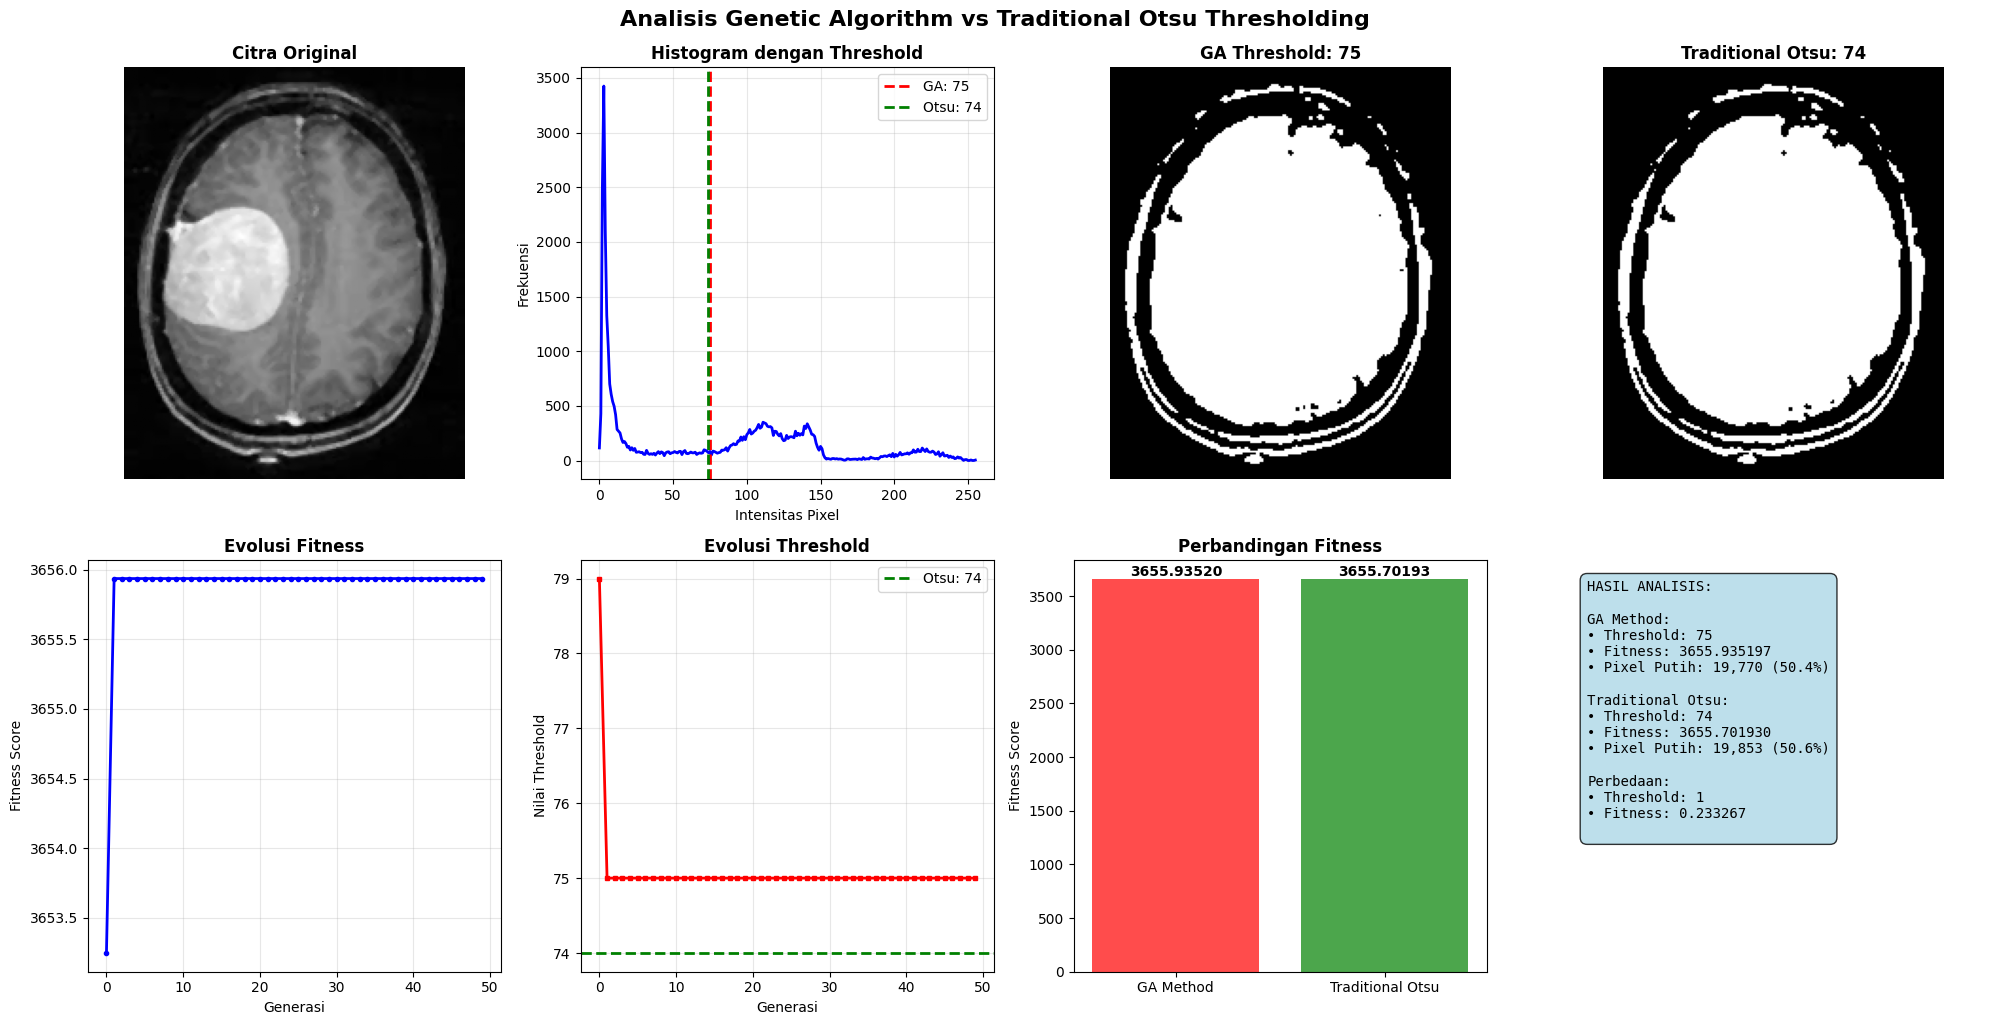


Simpan hasil analisis? (y/n): y
Hasil disimpan sebagai 'ga_otsu_analysis.png'

=== EKSPERIMEN SELESAI ===
Hasil tersimpan dalam variabel 'results'


In [ ]:
if __name__ == "__main__":
    # Jalankan eksperimen utama
    results = run_brain_tumor_segmentation()

    if results:
        print("\n=== EKSPERIMEN SELESAI ===")
        print("Hasil tersimpan dalam variabel 'results'")
    else:
        print("\nEksperimen gagal. Silakan periksa input dan coba lagi.")